Import libs and set seed:

In [4]:
import numpy as np
import torch
import random
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm
from matplotlib import pyplot as plt


def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)


def plot_stats(stats_tr, stats_to_plot, stats_val=None, eval_every=None, 
               labels=None, save=False, rx=None, ry=None):

    for i, stat in enumerate(stats_to_plot):

        label = stat if not labels else labels[i]

        plt.plot(range(1, len(stats_tr[stat])+1), stats_tr[stat],
                 label=label+' (TR)')

        if stats_val:
            plt.plot(range(eval_every, len(stats_tr[stat])+1, eval_every),
                     stats_val[stat], '.', label=label+' (VL)')

    plt.grid()

    plt.ylim(ry) if ry else plt.ylim(0)
    plt.xlim(rx) if rx else plt.xlim(0)

    plt.legend()

Load model:

In [5]:
models_dir = 'models_prova/'
model = '6968a042-5f83-11ee-b397-20677ceb0ed0'
checkpoint = torch.load(os.path.join(models_dir, model, 'checkpoint'), 
                        map_location='cpu')

Plot losses:

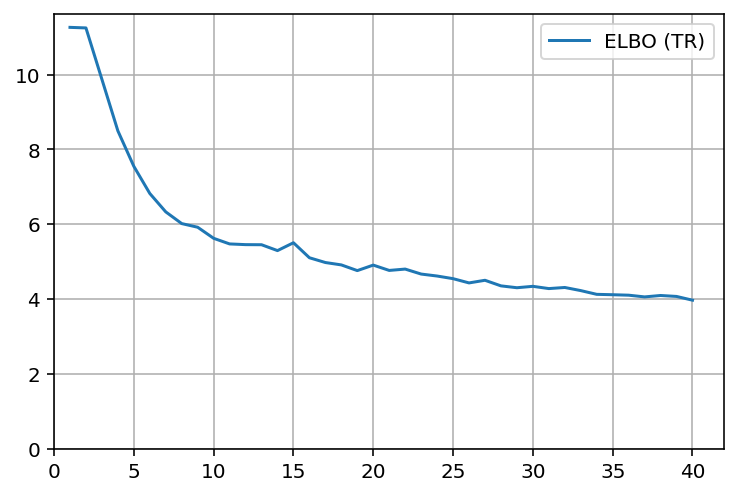

In [17]:
labeled_stats = [
    #('tot', 'ELBO'),
    #('acts', 'Structure'),
    #('pitches', 'Pitches'),
    #('dur', 'Duration'),
    #('rec', 'Rec. term'),
    #('kld', 'KLD'),
    #('beta*kld', 'beta * KLD')
]

stats = [s[0] for s in labeled_stats]
labels = [s[1] for s in labeled_stats]

tr_losses = checkpoint['tr_losses']
val_losses = checkpoint['val_losses']
eval_every = checkpoint['eval_every']

plot_stats(tr_losses, stats, stats_val=val_losses,
           eval_every=eval_every, labels=labels, rx=(0))

Plot accuracies:

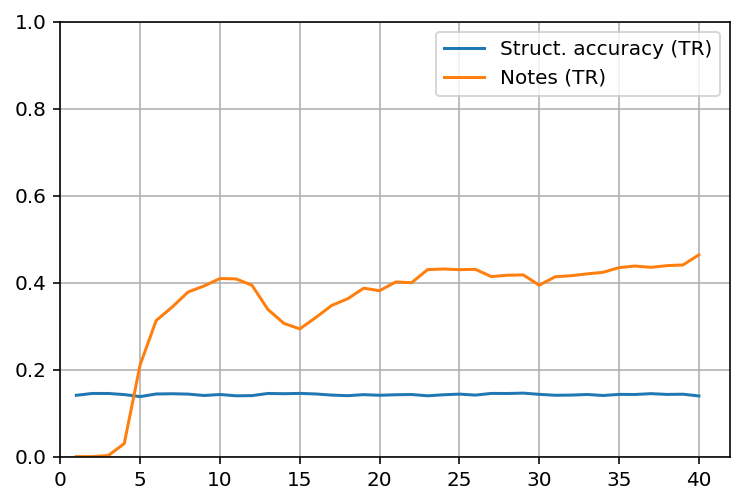

In [16]:
labeled_stats = [
    ('s_acc', 'Struct. accuracy'),
    #('s_precision', 'Struct. precision'),
    #('s_recall', 'Struct. recall'),
    #('s_f1', 'Struct. F1'),
    #('pitch', 'Pitches'),
    #('pitch_drums', 'Drums pitches'),
    #('pitch_non_drums', 'Non drums pitches'),
    #('dur', 'Duration'),
    ('note', 'Notes')
]

stats = [s[0] for s in labeled_stats]
labels = [s[1] for s in labeled_stats]

tr_losses = checkpoint['tr_accuracies']
val_losses = checkpoint['val_accuracies']
eval_every = checkpoint['eval_every']

plot_stats(tr_losses, stats, stats_val=val_losses,
           eval_every=eval_every, labels=labels, ry=(0, 1))

Current epoch:

In [ ]:
checkpoint['tot_batches']

Show the parameters of the current model:

In [ ]:
params = torch.load(os.path.join(models_dir, model, 'params'), map_location='cpu')
params

Learning rates:

In [ ]:
lrs = checkpoint['lrs']
plt.plot(range(1, len(lrs)+1), lrs, label='Lr')
plt.grid()
plt.ylim(0)
plt.xlim(0)

Betas:

In [ ]:
betas = checkpoint['betas']
plt.plot(range(1, len(betas)+1), betas, label='Beta')
plt.grid()
#plt.ylim(0, 0.001)
plt.xlim(0)

Reconstruct

In [ ]:
import torch
torch.cuda.set_device(3)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools
from torch_geometric.data.collate import collate


class MIDIDataset(Dataset):

    def __init__(self, dir, n_bars=2):
        self.dir = dir
        _, _, files = next(os.walk(self.dir))
        self.len = len(files)
        self.n_bars = n_bars

        
    def __len__(self):
        return self.len

    
    def _get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind+track, e[1][0]-e[0][0]) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            track_edges.extend(edges)
            track_edges.extend(inv_edges)

        return np.array(track_edges, dtype='long')

    
    def _get_onset_edges(self, acts, edge_type_ind=4):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def _get_next_edges(self, acts, edge_type_ind=5):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            
            next_edges.extend(edges)
            next_edges.extend(inv_edges)
            
        return np.array(next_edges, dtype='long')
    
    def _get_super_edges(self, num_nodes, edge_type_ind=6):
    
        super_edges = [(num_nodes, i, edge_type_ind, 0) for i in range(num_nodes)]
        inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
        
        super_edges.extend(inv_edges)
        
        return np.array(super_edges, dtype='long')
        
    
    def _get_node_features(self, acts, num_nodes):
        
        num_tracks = acts.shape[0]
        features = torch.zeros((num_nodes, num_tracks), dtype=torch.float)
        features[np.arange(num_nodes), np.stack(np.where(acts))[0]] = 1.
        
        return features


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)
        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # From (#tracks x #timesteps x ...) to (#bars x #tracks x #timesteps x ...)
        seq_tensor = seq_tensor.reshape(seq_tensor.shape[0], self.n_bars, -1,
                                        seq_tensor.shape[2], seq_tensor.shape[3])
        seq_tensor = seq_tensor.transpose(1, 0, 2, 3, 4)
        seq_acts = seq_acts.reshape(seq_acts.shape[0], self.n_bars, -1)
        seq_acts = seq_acts.transpose(1, 0, 2)
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[..., 0]
        onehot_p = np.zeros(
            (pitches.shape[0]*pitches.shape[1]*pitches.shape[2]*pitches.shape[3],
             131), 
            dtype=float
        )
        onehot_p[np.arange(0, onehot_p.shape[0]), pitches.reshape(-1)] = 1.
        onehot_p = onehot_p.reshape(pitches.shape[0], pitches.shape[1], 
                                    pitches.shape[2], pitches.shape[3], 131)
        
        # From decimals to one-hot (dur)
        durs = seq_tensor[..., 1]
        onehot_d = np.zeros(
            (durs.shape[0]*durs.shape[1]*durs.shape[2]*durs.shape[3],
             99),
            dtype=float
        )
        onehot_d[np.arange(0, onehot_d.shape[0]), durs.reshape(-1)] = 1.
        onehot_d = onehot_d.reshape(durs.shape[0], durs.shape[1], 
                                    durs.shape[2], durs.shape[3], 99)
        
        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot_p, onehot_d),
                                        axis=-1)
        
        graphs = []
        
        # Iterate over bars and construct a graph for each bar
        for i in range(self.n_bars):
            
            # Number of nodes
            n = torch.sum(torch.Tensor(seq_acts[i]), dtype=torch.long)
            
            # Get edges from boolean activations
            # Todo: optimize and refactor
            track_edges = self._get_track_edges(seq_acts[i])
            onset_edges = self._get_onset_edges(seq_acts[i])
            next_edges = self._get_next_edges(seq_acts[i])
            #super_edges = self._get_super_edges(n)
            edges = [track_edges, onset_edges, next_edges]
            
            # Concatenate edge tensors (N x 4) (if any)
            # First two columns -> source and dest nodes
            # Third column -> edge_type, Fourth column -> timestep distance
            no_edges = (len(track_edges) == 0 and 
                        len(onset_edges) == 0 and len(next_edges) == 0)
            if not no_edges:
                edge_list = np.concatenate([x for x in edges
                                              if x.size > 0])
                edge_list = torch.from_numpy(edge_list)
                
            # Adapt tensor to torch_geometric's Data
            # No edges: add fictitious self-edge
            edge_index = (torch.LongTensor([[0], [0]]) if no_edges else
                                   edge_list[:, :2].t().contiguous())
            attrs = (torch.Tensor([[0, 0]]) if no_edges else
                                           edge_list[:, 2:])

            # One hot timestep distance concatenated to edge type
            edge_attrs = torch.zeros(attrs.size(0), 1+seq_acts.shape[-1])
            edge_attrs[:, 0] = attrs[:, 0]
            edge_attrs[np.arange(edge_attrs.size(0)), attrs.long()[:, 1]+1] = 1
            #edge_attrs = torch.Tensor(attrs.float())
            
            node_features = self._get_node_features(seq_acts[i], n)
            is_drum = node_features[:, 0].bool()
            
            graphs.append(Data(edge_index=edge_index, edge_attrs=edge_attrs,
                               num_nodes=n, node_features=node_features,
                               is_drum=is_drum))
            
            
        # Merge the graphs corresponding to different bars into a single big graph
        graphs, _, inc_dict = collate(
            Data,
            data_list=graphs,
            increment=True,
            add_batch=True
        )
        
        # Change bars assignment vector name (otherwise, Dataloader's collate
        # would overwrite graphs.batch)
        graphs.bars = graphs.batch
        
        # Filter silences in order to get a sparse representation
        new_seq_tensor = new_seq_tensor.reshape(-1, new_seq_tensor.shape[-2],
                                                new_seq_tensor.shape[-1])
        src_mask = src_mask.reshape(-1, src_mask.shape[-1])
        new_seq_tensor = new_seq_tensor[seq_acts.reshape(-1).astype(bool)]
        src_mask = src_mask[seq_acts.reshape(-1).astype(bool)]
        
        new_seq_tensor = torch.Tensor(new_seq_tensor)
        seq_acts = torch.Tensor(seq_acts)
        graphs.x_seq = new_seq_tensor
        graphs.x_acts = seq_acts
        graphs.src_mask = src_mask
        
        # Todo: start with torch at mount
        #return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graphs, src_mask
        return graphs


In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj
from typing import Callable
from torch_geometric.nn.inits import reset

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')

def masked_edge_attrs(edge_attrs, edge_mask):
    return edge_attrs[edge_mask, :]


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps edge features :obj:`edge_attr` of shape :obj:`[-1,
            num_edge_features]` to shape
            :obj:`[-1, in_channels * out_channels]`, *e.g.*, defined by
            :class:`torch.nn.Sequential`.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        #num_dists: int,
        nn: Callable,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        dropout: Optional[float] = 0.1,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.nn = nn
        #self.num_dists = num_dists
        self.dropout = dropout
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))
        
        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        
        #self.dist_weights = Parameter(torch.Tensor(self.num_dists))

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        reset(self.nn)
        glorot(self.comp)
        glorot(self.root)
        #zeros(self.dist_weights)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None,
                edge_attr: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                attr = masked_edge_attrs(edge_attr, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size,
                                       edge_attr=attr)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        #weights = self.dist_weights[edge_attr.view(-1).long()]
        #weights = torch.diag(weights)
        #return torch.matmul(weights, x_j)
        weights = self.nn(edge_attr)
        weights = weights[..., :self.in_channels_l]
        weights = weights.view(-1, self.in_channels_l)
        ret = x_j * weights
        ret = F.relu(ret)
        ret = F.dropout(ret, p=self.dropout, training=self.training)
        return ret
    
        
        
    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

In [ ]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv#, RGCNConv
from torch_geometric.nn.norm import BatchNorm
from torch_geometric.nn.glob import GlobalAttention
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    

class MLP(nn.Module):
    
    def __init__(self, input_dim=256, hidden_dim=256, output_dim=256, num_layers=2,
                 act=True, dropout=0.1):
        super().__init__()
        
        assert num_layers >= 1
        
        self.layers = nn.ModuleList()
        
        if num_layers == 1:
            self.layers.append(nn.Linear(input_dim, output_dim))
        else:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
        
            for i in range(num_layers-2):
                self.layers.append(nn.Linear(hidden_dim, hidden_dim))

            self.layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.act = act
        self.p = dropout
        

    def forward(self, x):
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x)
            if self.act:
                x = F.relu(x)
        
        return x
    
    
class EncoderRNN(nn.Module):
    
    def __init__(self, input_size=240, hidden_size=256, num_layers=2, 
                 dropout=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True,
                            num_layers=num_layers, bidirectional=True)

    def forward(self, x, hidden):
        embedded = self.embedding(x).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden
    

class DecoderRNN(nn.Module):
    
    def __init__(self, hidden_size=256, output_size=240, num_layers=2, 
                 dropout=0.1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Linear(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True,
                            num_layers=num_layers, bidirectional=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output = self.embedding(x).view(1, 1, -1)
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


class GraphEncoder(nn.Module):
    
    def __init__(self, input_dim=256, hidden_dim=256, n_layers=3, 
                 num_relations=3, num_dists=32, batch_norm=False, dropout=0.1):
        super().__init__()
        
        self.layers = nn.ModuleList()
        self.norm_layers = nn.ModuleList()
        edge_nn = nn.Linear(num_dists, input_dim)
        self.batch_norm = batch_norm
        
        self.layers.append(RGCNConv(input_dim, hidden_dim,
                                    num_relations, edge_nn))
        if self.batch_norm:
            self.norm_layers.append(BatchNorm(hidden_dim))
        
        for i in range(n_layers-1):
            #edge_nn = nn.Linear(num_dists, input_dim)
            self.layers.append(RGCNConv(hidden_dim, hidden_dim,
                                        num_relations, edge_nn))
            if self.batch_norm:
                self.norm_layers.append(BatchNorm(hidden_dim))
            
        self.p = dropout
        

    def forward(self, data):
        x, edge_index, edge_attrs = data.x, data.edge_index, data.edge_attrs
        #batch = data.distinct_bars
        edge_type = edge_attrs[:, 0]
        edge_attr = edge_attrs[:, 1:]
        
        for i in range(len(self.layers)):
            residual = x
            x = F.dropout(x, p=self.p, training=self.training)
            x = self.layers[i](x, edge_index, edge_type, edge_attr)
            if self.batch_norm:
                x = self.norm_layers[i](x)
            x = F.relu(x)
            x = residual + x

        return x
    
    
class CNNEncoder(nn.Module):
    
    def __init__(self, output_dim=256, dense_dim=256, batch_norm=False,
                 dropout=0.1):
        super().__init__()
        
        if batch_norm:
            self.conv = nn.Sequential(
                # 4*32 --> 8*4*32
                nn.Conv2d(1, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                # 8*4*32 --> 8*4*8
                nn.MaxPool2d((1, 4), stride=(1, 4)),
                # 8*4*8 --> 16*4*8
                nn.Conv2d(8, 16, 3, padding=1),
                nn.BatchNorm2d(16),
                nn.ReLU(True)
            )
        else:
            self.conv = nn.Sequential(
                # 4*32 --> 8*4*32
                nn.Conv2d(1, 8, 3, padding=1),
                nn.ReLU(True),
                # 8*4*32 --> 8*4*8
                nn.MaxPool2d((1, 4), stride=(1, 4)),
                # 8*4*8 --> 16*4*8
                nn.Conv2d(8, 16, 3, padding=1),
                nn.ReLU(True)
            )
        
        self.flatten = nn.Flatten(start_dim=1)
        
        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(16*4*8, dense_dim),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dense_dim, output_dim)
        )
        
        
    def forward(self, x):
        
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = self.flatten(x)
        x = self.lin(x)
        
        return x
    

class CNNDecoder(nn.Module):
    
    def __init__(self, input_dim=256, dense_dim=256, batch_norm=False,
                 dropout=0.1):
        super().__init__()
        
        self.lin = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(input_dim, dense_dim),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(dense_dim, 16*4*8),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(16, 4, 8))

        if batch_norm:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=(1, 4), mode='nearest'),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.BatchNorm2d(8),
                nn.ReLU(True),
                nn.Conv2d(8, 1, 3, padding=1)
            )
        else:
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=(1, 4), mode='nearest'),
                nn.Conv2d(16, 8, 3, padding=1),
                nn.ReLU(True),
                nn.Conv2d(8, 1, 3, padding=1)
            )
        
        
    def forward(self, x):
        
        x = self.lin(x)
        x = self.unflatten(x)
        x = self.conv(x)
        
        return x.unsqueeze(1)
        

class Encoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        
        self.__dict__.update(kwargs)
        
        self.dropout_layer = nn.Dropout(p=self.dropout)
        
        
        self.notes_pitch_emb = nn.Linear(self.d_token_pitches, 
                                               self.d//2)
        
        self.bn_npe = nn.BatchNorm1d(num_features=self.d//2)
        
        self.drums_pitch_emb = nn.Linear(self.d_token_pitches, 
                                               self.d//2)
        
        self.bn_dpe = nn.BatchNorm1d(num_features=self.d//2)
        
        self.dur_emb = nn.Linear(self.d_token_dur, self.d//2)
        
        self.bn_de = nn.BatchNorm1d(num_features=self.d//2)
        
        self.chord_encoder = nn.Linear(self.d * (self.max_simu_notes-1),
                                       self.d)

        # Graph encoder
        self.graph_encoder = GraphEncoder(dropout=self.dropout, 
                                          input_dim=self.d,
                                          hidden_dim=self.d,
                                          n_layers=self.gnn_n_layers,
                                          num_relations=self.n_relations,
                                          batch_norm=self.batch_norm)
        
        gate_nn = nn.Sequential(
            MLP(input_dim=self.d, output_dim=1, num_layers=1, act=False,
                      dropout=self.dropout),
            nn.BatchNorm1d(1)
        )
        self.graph_attention = GlobalAttention(gate_nn)
        
        #self.context_bar_rnn = nn.GRU(input_size=self.d,
        #                              hidden_size=self.d//2,
        #                              num_layers=1,
        #                              bidirectional=True,
        #                              batch_first=True, 
        #                              dropout=self.dropout)
        
        self.bars_encoder_attr = nn.Linear(self.n_bars*self.d,
                                           self.d)
        
        
        self.cnn_encoder = CNNEncoder(dense_dim=self.d,
                                      output_dim=self.d,
                                      dropout=0,
                                      batch_norm=self.batch_norm)
        
        self.bars_encoder_struct = nn.Linear(self.n_bars*self.d,
                                             self.d)
        #self.struct_bar_rnn = nn.GRU(input_size=self.d,
        #                              hidden_size=self.d//2,
        #                              num_layers=1,
        #                              batch_first=True, 
        #                              dropout=self.dropout)
        
        self.linear_merge = nn.Linear(2*self.d, self.d)
        
        self.bn_lm = nn.BatchNorm1d(num_features=self.d)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(self.d, self.d)
        self.linear_log_var = nn.Linear(self.d, self.d)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):
        
        # No start of seq token
        x_seq = x_seq[:, 1:, :]
        
        # Get drums and non drums tensors
        drums = x_seq[x_graph.is_drum]
        src_mask_drums = src_mask[x_graph.is_drum]
        non_drums = x_seq[torch.logical_not(x_graph.is_drum)]
        src_mask_non_drums = src_mask[torch.logical_not(x_graph.is_drum)]
        
        # Permute dimensions to batch_first = False
        #drums = drums.permute(1, 0, 2)
        #non_drums = non_drums.permute(1, 0, 2)
        
        # Compute note/drums embeddings
        s = drums.size()
        drums_pitch = self.drums_pitch_emb(drums[..., :self.d_token_pitches])
        drums_pitch = self.bn_dpe(drums_pitch.view(-1, self.d//2))
        drums_pitch = drums_pitch.view(s[0], s[1], self.d//2)
        drums_dur = self.dur_emb(drums[..., self.d_token_pitches:])
        drums_dur = self.bn_de(drums_dur.view(-1, self.d//2))
        drums_dur = drums_dur.view(s[0], s[1], self.d//2)
        drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        #drums = self.dropout_layer(drums)
        # [n_nodes x max_simu_notes x d]
        
        s = non_drums.size()
        non_drums_pitch = self.notes_pitch_emb(non_drums[..., :self.d_token_pitches])
        non_drums_pitch = self.bn_npe(non_drums_pitch.view(-1, self.d//2))
        non_drums_pitch = non_drums_pitch.view(s[0], s[1], self.d//2)
        non_drums_dur = self.dur_emb(non_drums[..., self.d_token_pitches:])
        non_drums_dur = self.bn_de(non_drums_dur.view(-1, self.d//2))
        non_drums_dur = non_drums_dur.view(s[0], s[1], self.d//2)
        non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        #non_drums = self.dropout_layer(non_drums)
        # [n_nodes x max_simu_notes x d]
        
        #len_drums = self.max_simu_notes - torch.sum(src_mask_drums, dim=1)
        #len_non_drums = self.max_simu_notes - torch.sum(src_mask_non_drums, dim=1)
        
        #drums = pack_padded_sequence(drums, len_drums.cpu().view(-1),
        #                             enforce_sorted=False)
        #non_drums = pack_padded_sequence(non_drums, len_non_drums.cpu().view(-1),
        #                                 enforce_sorted=False)

        # Compute chord embeddings both for drums and non drums
        drums = self.chord_encoder(drums.view(-1, self.d*(self.max_simu_notes-1)))
        non_drums = self.chord_encoder(non_drums.view(-1, self.d*(self.max_simu_notes-1)))
        drums = F.relu(drums)
        non_drums = F.relu(non_drums)
        drums = self.dropout_layer(drums)
        non_drums = self.dropout_layer(non_drums)
        # [n_nodes x d]
        
        #hidden = torch.zeros(drums.size(1), )
        #drums = self.chord_encoder_drums(drums)[-1]
        #non_drums = self.chord_encoder(non_drums)[-1]
        #drums = torch.mean(drums, dim=0)
        #non_drums = torch.mean(non_drums, dim=0)
        
        #drums = self.dropout_layer(drums)
        #non_drums = self.dropout_layer(non_drums)
        
        # Merge drums and non-drums
        #out = torch.zeros((x_seq.size(0), self.d_model), 
        #                  device=self.device)
        out = torch.zeros((x_seq.size(0), self.d), 
                          device=self.device, dtype=torch.half)
        out[x_graph.is_drum] = drums
        out[torch.logical_not(x_graph.is_drum)] = non_drums
        # [n_nodes x d]
        
        #x_graph.x = torch.cat((x_graph.node_features, out), 1)
        x_graph.x = out
        x_graph.distinct_bars = x_graph.bars + self.n_bars*x_graph.batch
        out = self.graph_encoder(x_graph)
        # [n_nodes x d]
        
        with torch.cuda.amp.autocast(enabled=False):
            out = self.graph_attention(out,
                                       batch=x_graph.distinct_bars)
            # [bs x n_bars x d]
            
        out = out.view(-1, self.n_bars * self.d)
        # [bs x n_bars * d]
        out_attr = self.bars_encoder_attr(out)
        # [bs x d]
        
        # Process structure
        out = self.cnn_encoder(x_acts.view(-1, self.n_tracks,
                                                self.resolution*4))
        # [bs * n_bars x d]
        out = out.view(-1, self.n_bars * self.d)
        # [bs x n_bars * d]
        out_struct = self.bars_encoder_struct(out)
        # [bs x d]
        
        # Merge attr state and struct state
        out = torch.cat((out_attr, out_struct), dim=1)
        out = self.dropout_layer(out)
        out = self.linear_merge(out)
        out = self.bn_lm(out)
        out = F.relu(out)

        # Compute mu and log(std^2)
        out = self.dropout_layer(out)
        mu = self.linear_mu(out)
        log_var = self.linear_log_var(out)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        
        self.__dict__.update(kwargs)
        
        self.dropout_layer = nn.Dropout(p=self.dropout)

        self.lin_divide = nn.Linear(self.d, 2 * self.d)
        
        self.bn_ld = nn.BatchNorm1d(num_features=2*self.d)
        
        self.bars_decoder_attr = nn.Linear(self.d, self.d * self.n_bars)
        #self.context_bar_rnn = nn.GRU(input_size=self.d,
        #                              hidden_size=self.d//2,
        #                              num_layers=1,
        #                              bidirectional=True,
        #                              batch_first=True,
        #                              dropout=self.dropout)
        
        self.bars_decoder_struct = nn.Linear(self.d, self.d * self.n_bars)
        #self.struct_bar_rnn = nn.GRU(input_size=self.d//2,
        #                              hidden_size=self.d//2,
        #                              num_layers=1,
        #                              batch_first=True,
        #                              dropout=self.dropout)
        
        self.cnn_decoder = CNNDecoder(input_dim=self.d,
                                      dense_dim=self.d,
                                      dropout=0,
                                      batch_norm=self.batch_norm)
        
        self.graph_decoder = GraphEncoder(dropout=self.dropout,
                                          input_dim=self.d,
                                          hidden_dim=self.d,
                                          n_layers=self.gnn_n_layers,
                                          num_relations=self.n_relations,
                                          batch_norm=self.batch_norm)
        
        #gate_nn = nn.Sequential(
        #    MLP(input_dim=self.d, output_dim=1, num_layers=1, act=False,
        #              dropout=self.dropout),
        #    nn.BatchNorm1d(1)
        #)
        #feat_nn = nn.Sequential(
        #    MLP(input_dim=self.d, output_dim=self.d//2, num_layers=1,
        #              dropout=self.dropout),
        #    nn.BatchNorm1d(self.d//2)
        #)
        #self.graph_attention = GlobalAttention(gate_nn, feat_nn)
        
        self.chord_decoder = nn.Linear(self.d, self.d*(self.max_simu_notes-1))
        #self.chord_decoder = nn.GRU(input_size=self.d,
        #                            hidden_size=self.d,
        #                            num_layers=1,
        #                            dropout=self.dropout)
        #self.chord_decoder_drums = nn.GRU(input_size=self.d,
        #                                  hidden_size=self.d,
        #                                  num_layers=1,
        #                                  dropout=self.dropout)
        
        # Pitch and dur linear layers
        self.drums_pitch_emb = nn.Linear(self.d//2, self.d_token_pitches)
        self.notes_pitch_emb = nn.Linear(self.d//2, self.d_token_pitches)
        self.dur_emb = nn.Linear(self.d//2, self.d_token_dur)
        
        
    def forward_struct(self, z):
        # z: [bs x d]
        
        # Obtain z_structure and z_attributes from z
        #z = self.dropout_layer(z)
        z = self.lin_divide(z)
        z = self.bn_ld(z)
        z = F.relu(z)
        z = self.dropout_layer(z)
        # [bs x 2*d]
        
        out_struct = z[:, :self.d]
        # [bs x d] 
        out_struct = self.bars_decoder_struct(out_struct)
        # [bs x n_bars * d]
        
        out_struct = self.cnn_decoder(out_struct.reshape(-1, self.d))
        
        return out_struct


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask,
                inference=False):
        # z: [bs x d]
        
        # Obtain z_structure and z_attributes from z
        #z = self.dropout_layer(z)
        z = self.lin_divide(z)
        z = self.bn_ld(z)
        z = F.relu(z)
        z = self.dropout_layer(z)
        # [bs x 2*d]
        
        out_struct = z[:, :self.d]
        # [bs x d] 
        out_struct = self.bars_decoder_struct(out_struct)
        # [bs x n_bars * d]
        
        out_struct = self.cnn_decoder(out_struct.reshape(-1, self.d))
        out_struct = out_struct.view(x_acts.size())
        
        # Decode attributes
        out = z[:, self.d:]
        # [bs x d]
        out = self.bars_decoder_attr(out)
        # [bs x n_bars * d]
        
        # Initialize node features with corresponding z_bar
        # and propagate with GNN
        _, counts = torch.unique(x_graph.distinct_bars, return_counts=True)
        out = out.view(-1, self.d)
        out = torch.repeat_interleave(out, counts, axis=0)
        # [n_nodes x d]
        
        # Add one-hot encoding of tracks
        # Todo: use also edge info
        #x_graph.x = torch.cat((x_graph.node_features, out), 1)
        x_graph.x = out
        out = self.graph_decoder(x_graph)
        # [n_nodes x d]
        #print("Node decodings:", node_decs.size())
        
        
        #out = torch.matmul(out, self.chord_decoder.weight)
        out = self.chord_decoder(out)
        # [n_nodes x max_simu_notes * d]
        out = out.view(-1, self.max_simu_notes-1, self.d)
        
        drums = out[x_graph.is_drum]
        non_drums = out[torch.logical_not(x_graph.is_drum)]
        # [n_nodes(dr/non_dr) x max_simu_notes x d]
        
        # Obtain final pitch and dur decodings
        # (softmax to be applied outside the model)
        non_drums = self.dropout_layer(non_drums)
        drums = self.dropout_layer(drums)
        
        drums_pitch = self.drums_pitch_emb(drums[..., :self.d//2])
        drums_dur = self.dur_emb(drums[..., self.d//2:])
        drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        #drums_pitch = torch.matmul(drums[..., :self.d//2], self.drums_pitch_emb.weight)
        #drums_dur = torch.matmul(drums[..., self.d//2:], self.dur_emb.weight)
        #drums = torch.cat((drums_pitch, drums_dur), dim=-1)
        # [n_nodes(dr) x max_simu_notes x d_token]
        non_drums_pitch = self.notes_pitch_emb(non_drums[..., :self.d//2])
        non_drums_dur = self.dur_emb(non_drums[..., self.d//2:])
        non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        #non_drums_pitch = torch.matmul(non_drums[..., :self.d//2], self.notes_pitch_emb.weight)
        #non_drums_dur = torch.matmul(non_drums[..., self.d//2:], self.dur_emb.weight)
        #non_drums = torch.cat((non_drums_pitch, non_drums_dur), dim=-1)
        # [n_nodes(non_dr) x max_simu_notes x d_token]
        
        # Merge drums and non-drums
        out = torch.zeros((x_seq.size(0), x_seq.size(1), x_seq.size(2)),
                          device=self.device, dtype=torch.half)
        out[x_graph.is_drum] = drums
        out[torch.logical_not(x_graph.is_drum)] = non_drums
        
        out = out.view(x_seq.size())

        return out, out_struct


class VAE(nn.Module):

    def __init__(self, **kwargs):
        super().__init__()
        
        self.encoder = Encoder(**kwargs)
        self.decoder = Decoder(
            **kwargs
        )
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask,
                inference=False):
        
        #src_mask = src_mask.view(-1, src_mask.size(-1))
        
        # Encoder pass
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        
        # Reparameterization trick
        z = torch.exp(0.5*log_var)
        z = z * torch.randn_like(z)
        #print("eps:", eps.size())
        z = z + mu
        
        # Shifting target sequence and mask for transformer decoder
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        # Decoder pass
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask,
                           inference=inference)
        
        return out, mu, log_var


In [ ]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [ ]:
def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [ ]:
model = 'models/2barsGNNDEF/'

In [ ]:
checkpoint = torch.load(os.path.join(model, 'checkpoint'), map_location='cpu')

In [ ]:
state_dict = checkpoint['model_state_dict']
params = torch.load(os.path.join(model, 'params'), map_location='cpu')
vae = VAE(**params['model'], device=device).to(device)

In [ ]:
params

In [ ]:
vae.load_state_dict(state_dict)
vae.eval()

In [ ]:
from torch.utils.data import Subset
import numpy as np
import os
from torch.utils.data import random_split

n_bars = 2
bs = 256
nw = 4

ds_dir = "/data/cosenza/datasets/preprocessed_2bars/"
dataset = MIDIDataset(ds_dir, n_bars=n_bars)
print('Dataset len:', len(dataset))

loader = DataLoader(dataset, batch_size=bs, shuffle=False, num_workers=nw)
#print(len(subset))


train_len = int(0.7 * len(dataset)) 
valid_len = int(0.01 * len(dataset))
test_len = len(dataset) - train_len - valid_len
#train_dataset, valid_dataset, test_dataset = random_split(model_dataset, (train_count, valid_count, test_count))
tr_set, vl_set, ts_set = random_split(dataset, (train_len, valid_len, test_len))

trainloader = DataLoader(tr_set, batch_size=bs, shuffle=True, num_workers=nw)
validloader = DataLoader(vl_set, batch_size=bs, shuffle=False, num_workers=nw)
#testloader = DataLoader(ts_set, batch_size=64, shuffle=False, num_workers=4)

tr_len = len(tr_set)
vl_len = len(vl_set)
ts_len = len(ts_set)

print('TR set len:', len(tr_set))
print('VL set len:', len(vl_set))
print('TS set len:', len(ts_set))

In [ ]:
with torch.no_grad():
    for idx, inputs in enumerate(trainloader):

        x_graph = inputs.to(device)
        x_seq, x_acts, src_mask = x_graph.x_seq, x_graph.x_acts, x_graph.src_mask
        tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(device)

        # Forward pass, get the reconstructions
        with torch.cuda.amp.autocast():
            outputs, mu, log_var = vae(x_seq, x_acts, x_graph, src_mask, tgt_mask)

        break
    

seq_rec, acts_rec  = outputs

Reconstruct activations

In [ ]:
def _pitches_accuracy(seq_rec, x_seq, is_drum=None, drums=None):
        
    if drums is not None:
        if drums:
            seq_rec = seq_rec[is_drum]
            x_seq = x_seq[is_drum]
        else:
            seq_rec = seq_rec[torch.logical_not(is_drum)]
            x_seq = x_seq[torch.logical_not(is_drum)]

    pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
    pitches_rec = torch.argmax(pitches_rec, dim=-1)
    pitches_true = torch.argmax(x_seq[..., :131], dim=-1)

    #print("All EOS pitches?", torch.all(pitches_rec == 129))

    mask = (pitches_true != 130)
    #mask = torch.logical_and(pitches_true != 128,
     #                        pitches_true != 129)
    #mask = torch.logical_and(mask,
     #                        pitches_true != 130)

    preds_pitches = (pitches_rec == pitches_true)
    preds_pitches = torch.logical_and(preds_pitches, mask)

    return torch.sum(preds_pitches) / torch.sum(mask)

In [ ]:
new_seq = x_seq[..., 1:, :]
_pitches_accuracy(seq_rec, new_seq)

In [ ]:
from matplotlib import pyplot as plt
print(acts_rec.size())
print(x_acts.size())
print(x_seq.size())
print(seq_rec.size())

In [ ]:
def plot_struct(s):
    plt.figure(figsize=(10, 10))
    plt.pcolormesh(s.detach().cpu().numpy(), edgecolors='k', linewidth=1)
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xticks(range(0, s.size(1), 8), range(1, 5))
    plt.yticks(range(0, 4), range(1, 5))
    ax.invert_yaxis()

Reconstructed:

In [ ]:
s = torch.sigmoid(acts_rec[3])
s[s > 0.5] = 1
s[s <= 0.5] = 0

plot_struct(s)

Real:

In [ ]:
s = x_acts[3]
plot_struct(s)

In [ ]:
# Construct dense reconstruction from sparse representation

def dense_from_sparse(seq, acts, bars):
    
    dtype = seq.dtype
    
    acts = acts.view(-1, bars, acts.size(-2), acts.size(-1))
    dtype = seq.dtype
    seq_dense = torch.zeros((acts.size(0), acts.size(1), acts.size(2),
                             acts.size(3), seq.size(-2), seq.size(-1)),
                            dtype=dtype).to(device)

    size = seq_dense.size()

    seq_dense = seq_dense.view(-1, seq_dense.size(-2), seq_dense.size(-1))

    silence = torch.zeros((seq_dense.size(-2), seq_dense.size(-1)),
                            dtype=dtype).to(device)
    silence[:, 129] = 1. # eos token

    seq_dense[acts.bool().view(-1)] = seq
    seq_dense[torch.logical_not(acts.bool().view(-1))] = silence

    seq_dense = seq_dense.view(size)
    
    return seq_dense

In [ ]:
seq_rec_dense = dense_from_sparse(seq_rec, x_acts, bars=n_bars)
x_seq_dense = dense_from_sparse(x_seq, x_acts, bars=n_bars)

In [ ]:
# Collapse bars dimension
seq_rec_dense = seq_rec_dense.permute(0, 2, 1, 3, 4, 5)
x_seq_dense = x_seq_dense.permute(0, 2, 1, 3, 4, 5)

print(seq_rec_dense.size())

size = [
    seq_rec_dense.size(0),
    seq_rec_dense.size(1),
    -1,
    seq_rec_dense.size(4),
    seq_rec_dense.size(5)
]

seq_rec_dense = seq_rec_dense.reshape(size)
size[-2] = x_seq_dense.size(-2)
x_seq_dense = x_seq_dense.reshape(size)

In [ ]:
music_real = x_seq_dense[12]
music_rec = seq_rec_dense[12]

In [ ]:
RESOLUTION = 8

#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    dur = torch.argmax(dur) + 1
                    
                    if dur == 97 or dur == 98 or dur == 99:
                        dur = 4
                        continue
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
                    #notes.append(muspy.Note(ts, pitch.item(), dur, 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

In [ ]:
import muspy
from matplotlib import pyplot as plt

prefix = "data/music/"

real = from_tensor_to_muspy(music_real, track_data)

fig, axs_ = plt.subplots(4, sharex=True, figsize=(10,10))
fig.subplots_adjust(hspace=0)
axs = axs_.tolist()
muspy.show_pianoroll(music=real, yticklabel='off', grid_axis='off', axs=axs)
plt.savefig(prefix + "real" + ".png", dpi=200)
muspy.write_midi(prefix + "real" + ".mid", real)

In [ ]:
rec = from_tensor_to_muspy(music_rec, track_data)

fig, axs_ = plt.subplots(4, sharex=True, figsize=(10,10))
fig.subplots_adjust(hspace=0)
axs = axs_.tolist()

muspy.show_pianoroll(rec, yticklabel='off', grid_axis='off', axs=axs)
plt.savefig(prefix + "rec" + ".png", dpi=200)
muspy.write_midi(prefix + "rec" + ".mid", rec)

In [ ]:
prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)

In [ ]:
params = {
    'n_tracks': 4,
    'dropout': 0.1,
    'd_token': 230,
    'd_model': 256,
    'n_head_transf': 2,
    'n_layers_transf': 2,
    'gnn_input_dim': 256 + 4,
    'gnn_n_layers': 3,
    'd_latent': 256,
    'resolution': 8
}

Generation

In [ ]:
z = torch.normal(torch.zeros((256, 512),
                             device=vae.decoder.device),
                 torch.ones((256, 512),
                            device=vae.decoder.device))

In [ ]:
z.size()

In [ ]:
# Obtain z_structure and z_attributes from z
#z = self.dropout_layer(z)
z = vae.decoder.lin_divide(z)
z = vae.decoder.bn_ld(z)
z = F.relu(z)
z = vae.decoder.dropout_layer(z)
# [bs x 2*d]

out_struct = z[:, :vae.decoder.d]
# [bs x d] 
out_struct = vae.decoder.bars_decoder_struct(out_struct)
# [bs x n_bars * d]

out_struct = vae.decoder.cnn_decoder(out_struct.reshape(-1, vae.decoder.d))
out_struct

In [ ]:
out_struct.size()

In [ ]:
acts_rec = torch.sigmoid(out_struct.view(256, 2, 4, 32))
acts_rec[acts_rec < 0.5] = 0
acts_rec[acts_rec >= 0.5] = 1
acts_rec

In [ ]:
plt.figure(figsize=(10, 10))
plt.pcolormesh(acts_rec[1, 0].detach().cpu().numpy(), edgecolors='k', linewidth=1)
ax = plt.gca()
ax.set_aspect('equal')
plt.xticks(range(0, acts_rec[1, 0].size(1), 8), range(1, 5))
plt.yticks(range(0, 4), range(1, 5))
ax.invert_yaxis()

In [ ]:
acts_rec[0].size()